In [2]:
# ML_in_Finance-2D-CNNs
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

In [3]:
from __future__ import print_function
import keras

from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.datasets import mnist
from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import pylab as pl
import matplotlib.cm as cm

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


The training set has 60000 observations of 28x28 images with one grayscale  input channel.

In [24]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape))
convout1 = Activation('relu')
model.add(convout1)
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_3 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
__________

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

In [23]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
 2432/60000 [>.............................] - ETA: 1:28 - loss: 1.7295 - acc: 0.4260

KeyboardInterrupt: 

In [5]:
Y_pred = model.predict(x_test)
# Convert one-hot to index
y_pred = np.argmax(Y_pred, axis=1)

In [21]:
np.shape(Y_pred)

(10000, 10)

In [6]:
y_test_= np.argmax(y_test, axis=1)

In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.98      0.96      0.97       974
           9       0.97      0.98      0.97      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [8]:
from keras import backend as K

In [9]:
# K.learning_phase() is a flag that indicates if the network is in training or
# predict phase. It allow layer (e.g. Dropout) to only be applied during training
inputs = [K.learning_phase()] + model.inputs

_convout1_f = K.function(inputs, [convout1.output])
def convout1_f(X):
    # The [0] is to disable the training phase flag
    return _convout1_f([0] + [X])

In [10]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

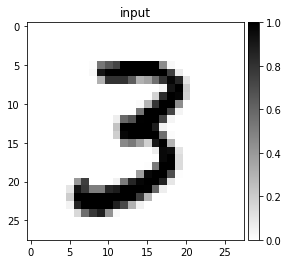

In [11]:
i = 4600

# Visualize the first layer of convolutions on an input image
X = x_test[i:i+1]

pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

In [12]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, imshape, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[3]
    #imshape = imgs.shape[0:2]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[:,:,:,i].reshape(imshape[0],imshape[1])#imgs[i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

In [13]:
# Visualize weights
W = model.layers[0].get_weights() #W.get_value(borrow=True)
#W = np.squeeze(W)[0]
print("W shape : ", W[0].shape)

W shape :  (3, 3, 1, 32)


/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


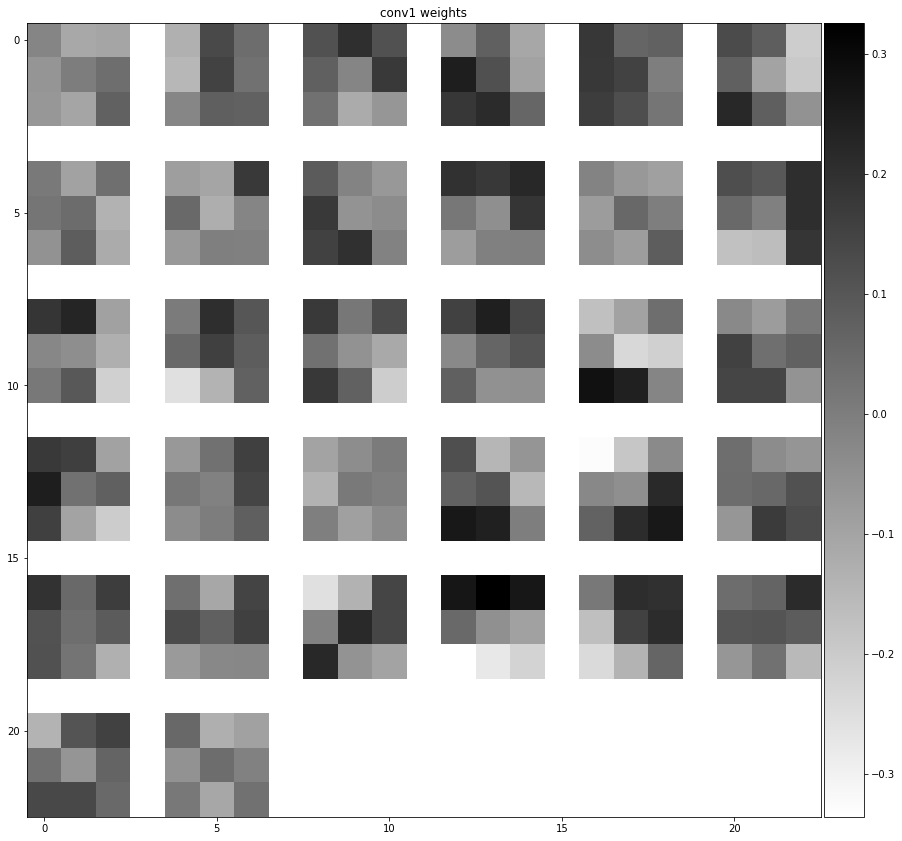

In [14]:
pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W[0], 6, 6, [3,3]), cmap=cm.binary)

In [15]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)[0]
print("C1 shape : ", C1.shape)

C1 shape :  (1, 26, 26, 32)


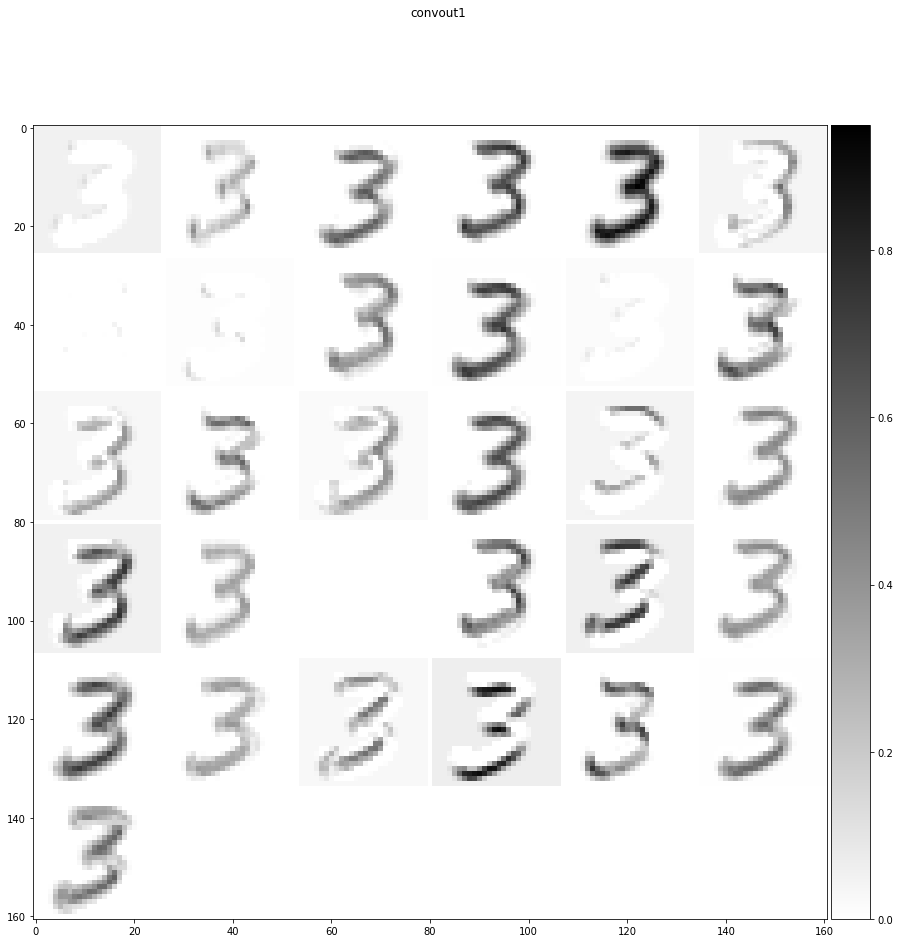

In [16]:
pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6,[26,26]), cmap=cm.binary)